In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [2]:
min_samples = 5
min_cluster_size = min_samples
data = np.load("data.npy")
knn = NearestNeighbors(n_neighbors=10, metric='euclidean').fit(data).kneighbors()

## Check API and plots

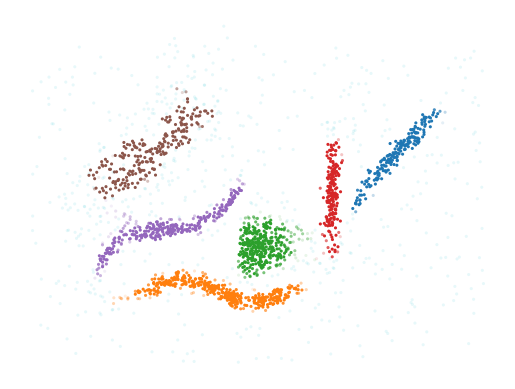

In [3]:
from plscan import PLSCAN

# the input contains k=5 mutual reachability distance!
c = PLSCAN().fit(knn)
plt.scatter(
    *data.T,
    c=c.labels_ % 10,
    alpha=np.maximum(0.1, c.probabilities_),
    s=5,
    linewidth=0,
    cmap="tab10",
)
plt.axis("off")
plt.show()

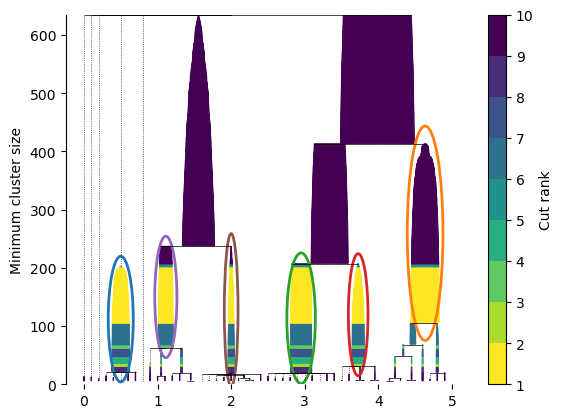

In [4]:
c.leaf_tree_.plot(select_clusters=True)
plt.show()

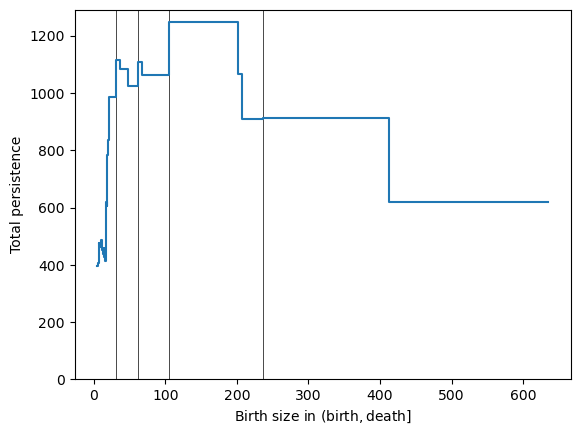

In [5]:
layers, peaks = c.cluster_layers(
    # min_size=16.0, # min cluster size threshold
    # max_size=80,   # max cluster size threshold
    # height=600,    # persistence threshold
    # threshold=25,  # persistence difference between the peak and neighbors
    n_peaks=4,     # keep only the n most persistent peaks after all thresholds
)

c.persistence_trace_.plot()
plt.vlines(list(zip(*layers))[0], *plt.ylim(), color="k", linewidth=0.5, zorder=1)
# plt.xlim([0, 125])
plt.show()

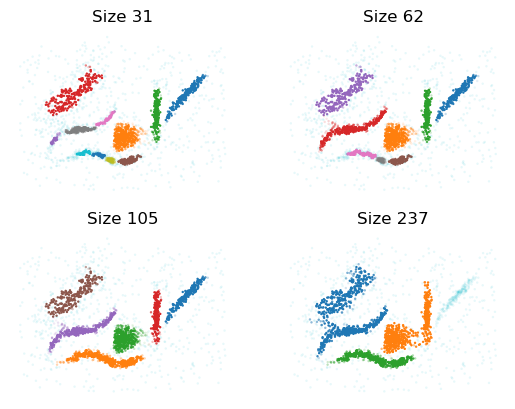

In [6]:
n_rows = int(np.ceil(np.sqrt(len(layers))))
n_cols = n_rows
plt.figure()
for i, (size, labels, probs) in enumerate(layers):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(
        *data.T,
        c=labels % 10,
        alpha=np.maximum(0.1, probs),
        s=3,
        linewidth=0,
        cmap="tab10",
    )
    plt.title(f"Size {int(size)}")
    plt.axis("off")
plt.show()

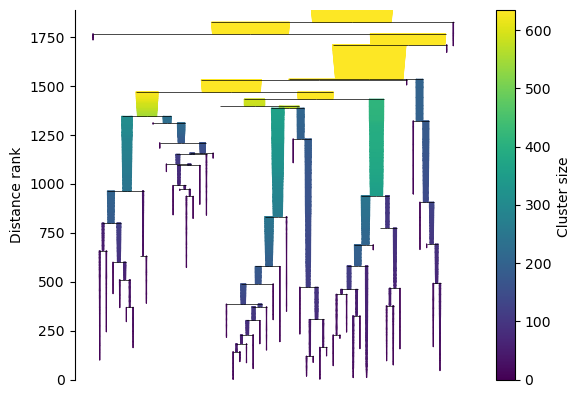

In [7]:
c.condensed_tree_.plot()
plt.show()

## Timing: 

Check individual function times

In [24]:
from plscan.api import *

# Define all internal variables so we can time each function separately
num_points = data.shape[0]
selected_clusters = c.selected_clusters_
trace = c._persistence_trace
sorted_mst = c._minimum_spanning_tree
condensed_tree = c._condensed_tree
leaf_tree = c._leaf_tree
linkage_tree = c._linkage_tree
sample_weights = None
min_cluster_size = c.min_cluster_size
max_cluster_size = c.max_cluster_size
graph = knn_to_csr(*knn)
graph = SparseGraph(graph.data, graph.indices, graph.indptr)
core_distances = c.core_distances_
mut_graph = compute_mutual_reachability(graph, core_distances)
spanning_tree = compute_spanning_forest(mut_graph)

In [ ]:
%%timeit
graph = knn_to_csr(*knn)
SparseGraph(graph.data, graph.indices, graph.indptr)

31.5 μs ± 480 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit
extract_core_distances(graph, min_samples=min_samples, is_sorted=True)

3.56 μs ± 327 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [27]:
%%timeit
compute_mutual_reachability(graph, core_distances)

23.2 μs ± 1.27 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
%%timeit
compute_spanning_forest(mut_graph)

46.2 μs ± 72.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
%%timeit
order = np.argsort(spanning_tree.distance)
SpanningTree(
    parent=spanning_tree.parent[order],
    child=spanning_tree.child[order],
    distance=spanning_tree.distance[order],
)

50.1 μs ± 182 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [30]:
%%timeit
linkage_tree = compute_linkage_tree(sorted_mst, num_points, sample_weights=sample_weights)

18.6 μs ± 52.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
%%timeit 
compute_condensed_tree(
    linkage_tree,
    sorted_mst,
    num_points,
    min_cluster_size=min_cluster_size,
    max_cluster_size=max_cluster_size,
    sample_weights=sample_weights,
)

8.45 μs ± 71.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
%%timeit compute_leaf_tree(condensed_tree, num_points, min_cluster_size=min_cluster_size)

1.61 μs ± 7.84 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
%%timeit compute_bi_persistence(leaf_tree, condensed_tree, num_points)

32.8 μs ± 231 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit
compute_size_persistence(leaf_tree)

1.91 μs ± 7.41 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
%%timeit
most_persistent_clusters(leaf_tree, trace)

3.55 μs ± 13.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
%%timeit
compute_cluster_labels(leaf_tree, condensed_tree, selected_clusters, num_points)

3.89 μs ± 32 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
